Epoch 1/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 293s 91ms/step - accuracy: 0.0353 - loss: 7.8783
Epoch 2/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 316s 89ms/step - accuracy: 0.0492 - loss: 6.7285
Epoch 3/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 324s 90ms/step - accuracy: 0.0504 - loss: 6.6379
Epoch 4/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 312s 87ms/step - accuracy: 0.0528 - loss: 6.5927
Epoch 5/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 288s 91ms/step - accuracy: 0.0511 - loss: 6.6115
Epoch 6/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 319s 90ms/step - accuracy: 0.0512 - loss: 6.6144
Epoch 7/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 335s 94ms/step - accuracy: 0.0496 - loss: 6.6197
Epoch 8/20
3176/3176 ━━━━━━━━━━━━━━━━━━━━ 311s 91ms/step - accuracy: 0.0501 - loss: 6.6051
Model Accuracy: 0.0525
Enter a sentence: But your
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
Next word prediction: the


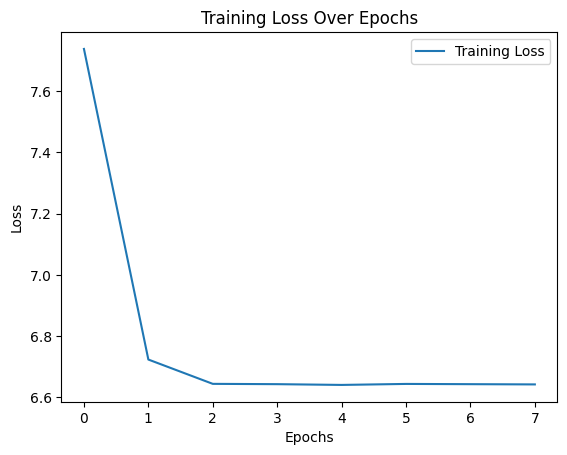

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
def load_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text.lower()  # Convert text to lowercase

# Dataset path
file_path = '/content/1661-0.txt'  # Replace with the path to your dataset
text = load_text(file_path)

# Preprocess text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])  # Fit tokenizer on the entire dataset (text)
total_words = len(tokenizer.word_index) + 1  # Get total words in vocabulary

# Create input sequences
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]  # Convert line to sequence of integers
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]  # Create n-grams of length i+1
        input_sequences.append(n_gram_sequence)  # Append to input_sequences list

# Pad sequences and create predictors and label
max_sequence_len = max([len(seq) for seq in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = to_categorical(y, num_classes=total_words)

# Build the LSTM model
model = Sequential()
model.add(Embedding(total_words, 100))  # Removed input_length as it’s inferred automatically
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='loss', patience=3)
history = model.fit(X, y, epochs=20, verbose=1, callbacks=[early_stop])

# Evaluate model accuracy
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f'Model Accuracy: {accuracy:.4f}')

# Predict the next word based on user input
def predict_next_word(model, tokenizer, text, max_sequence_len):
    # Convert input text to sequence of integers
    token_list = tokenizer.texts_to_sequences([text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len - 1, padding='pre')

    # Predict the next word
    predicted = np.argmax(model.predict(token_list), axis=-1)

    # Map the predicted integer back to the word
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            return word
    return ""

# Function to interact with the user and predict next word
def get_user_input_and_predict():
    user_input = input("Enter a sentence: ")  # Take user input
    next_word = predict_next_word(model, tokenizer, user_input, max_sequence_len)
    print(f"Next word prediction: {next_word}")

# Get user input and predict the next word
get_user_input_and_predict()

# Plot training loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Over Epochs')
plt.show()
